# `Dataset #2: COVID 19 Features`

In [19]:
import requests
import pandas as pd
import json

# India Cases and Deaths

In [20]:
# Make a GET request to the COVID-19 API endpoint for daily deaths and positive cases data
url = "https://api.covid19api.com/country/india?from=2020-01-01T00:00:00Z&to=2023-01-01T00:00:00Z"
response = requests.get(url)

# Parse the JSON response and extract the daily deaths and positive cases data
data = json.loads(response.text)
dates = [d['Date'] for d in data]
deaths = [d['Deaths'] for d in data]
cases = [d['Confirmed'] for d in data]

# Create a pandas dataframe to store the daily deaths and positive cases data
india_df = pd.DataFrame({'Date': dates, 'Deaths': deaths, 'Cases': cases})

#converting Date column to dates only to eliminate time variable
india_df['Date'] = pd.to_datetime(india_df['Date']).dt.date

#converting Date column to string to prepare for merge 
india_df['Date'] = india_df['Date'].astype(str)

# Display the df
india_df

,Date,Deaths,Cases
0,2020-01-22,0,0
1,2020-01-23,0,0
2,2020-01-24,0,0
3,2020-01-25,0,0
4,2020-01-26,0,0
...,...,...,...
1071,2022-12-28,530698,44679139
1072,2022-12-29,530699,44679382
1073,2022-12-30,530702,44679608
1074,2022-12-31,530705,44679873


# India Vaccinations

Data source: https://github.com/owid/covid-19-data

In [21]:
# Open the JSON file and load the data
with open('raw_covid_data/owid-covid-data.json', 'r') as f:
    data = json.load(f)

# Extract the data for India only
india_data = data['IND']['data']

# Extract the "date" and "total_vaccinations" data for India
india_vaccination_data = [(entry['date'], entry['total_vaccinations']) for entry in india_data if 'total_vaccinations' in entry]

# Create a Pandas DataFrame out of this data
vaccinations_df = pd.DataFrame(india_vaccination_data, columns=['Date', 'Total Vaccinations'])

# Convert the "total vaccinations" column to a standard decimal format
pd.options.display.float_format = '{:.2f}'.format
vaccinations_df['Total Vaccinations'] = vaccinations_df['Total Vaccinations'].astype(float)

#vaccinations_df['Date'] = vaccinations_df['Date'].astype(str)

#Dates that I'm missing that I will need to manually add
#(2020, 1, 12), (2020, 2, 12), (2020, 11, 17), (2020, 11, 18), (2020, 11, 19), (2020, 12, 1), (2020, 12, 2), (2020, 12, 6), (2020, 12, 7), (2020, 12, 9), (2020, 12, 12), (2020, 12, 16), (2020, 12, 19), (2020, 12, 20), (2020, 12, 23), (2020, 12, 31), (2021, 1, 2), (2021, 1, 4), (2021, 1, 6), (2021, 1, 7), (2021, 1, 9)

# creating a list of dates present in Pixstory dataset but not in my vaccinations dataset
additional_dates = [('2020', '1', '12'), ('2020', '2', '12'), ('2020', '11', '17'), ('2020', '11', '18'), ('2020', '11', '19'),
             ('2020', '12', '2'), ('2020', '12', '6'), ('2020', '12', '9'), ('2020', '12', '12'), ('2020', '12', '16'),
             ('2020', '12', '19'), ('2020', '12', '20'), ('2020', '12', '23'), ('2020', '12', '31'), ('2021', '1', '2'),
             ('2021', '1', '6'), ('2021', '1', '7'), ('2021', '1', '9')]


#turning this list into a dataframe
additional_dates_df = pd.DataFrame(additional_dates, columns=['Year', 'Month', 'Day'])

#converting the date column to datetime format to retrieve the date only
additional_dates_df['Date'] = pd.to_datetime(additional_dates_df[['Year', 'Month', 'Day']]).dt.date

# concatenating the two dataframes to create a dataframe that includes dates present from pixstory dataset
final_vaccinations_df = pd.concat([additional_dates_df, vaccinations_df], ignore_index=True)

#dropping columns that we don't need; redundant 
final_vaccinations_df= final_vaccinations_df.drop(['Year', 'Month', 'Day'], axis=1)

# replace NaN with zero
final_vaccinations_df.fillna(0, inplace=True)

# converting date column to string to prepare for merge
final_vaccinations_df['Date'] = final_vaccinations_df['Date'].astype(str)

# Printing the DataFrame
final_vaccinations_df.head(30)

,Date,Total Vaccinations
0,2020-01-12,0.00
1,2020-02-12,0.00
2,2020-11-17,0.00
3,2020-11-18,0.00
4,2020-11-19,0.00
5,2020-12-02,0.00
6,2020-12-06,0.00
7,2020-12-09,0.00
8,2020-12-12,0.00
9,2020-12-16,0.00


# Merge


In [22]:
#Merging the DataFrames on the 'Date' column
merged_df = pd.merge(india_df, final_vaccinations_df, on='Date')

#Creating new columns that find the difference between each row and the previous row to find new reports rather than cumulative
merged_df['New COVID Cases'] = merged_df['Cases'].diff().fillna(0).astype(int)
merged_df['New Deaths'] = merged_df['Deaths'].diff().fillna(0).astype(int)
merged_df['New Vaccinations'] = merged_df['Total Vaccinations'].diff().fillna(0).astype(int)

#Dropping columns we no longer need
final_covid_df = merged_df.drop(['Cases', 'Deaths', 'Total Vaccinations'], axis=1)

# saving the data frame as a CSV file
final_covid_df.to_csv('Final_COVID_Data.csv', index=False)

final_covid_df

,Date,New COVID Cases,New Deaths,New Vaccinations
0,2020-02-12,0,0,0
1,2020-11-17,8912904,130993,0
2,2020-11-18,45576,585,0
3,2020-11-19,45882,584,0
4,2020-12-02,530599,6486,0
...,...,...,...,...
707,2022-12-28,268,2,90596
708,2022-12-29,243,1,95882
709,2022-12-30,226,3,84200
710,2022-12-31,265,3,88286


# Visualizations 

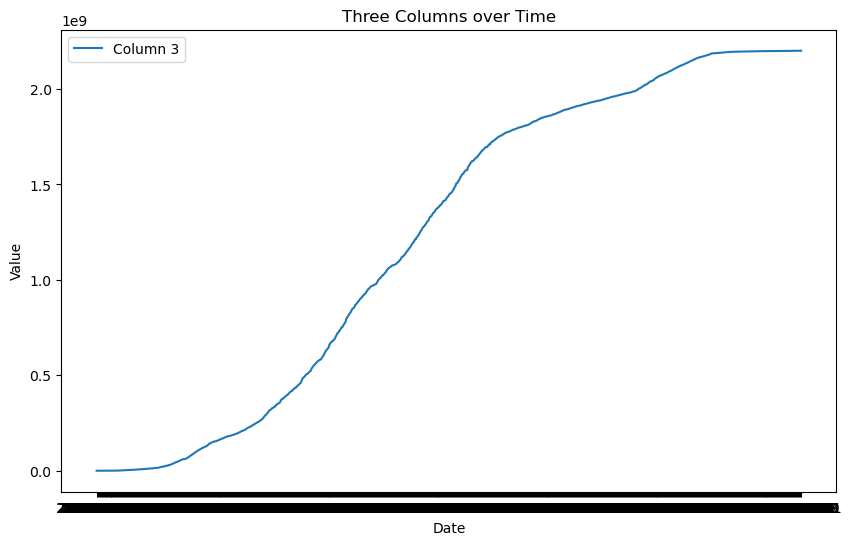

In [23]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the three columns against the date column
#plt.plot(merged_df['Date'], merged_df['New COVID Cases'], label='Column 1')
#plt.plot(merged_df['Date'], merged_df['New Deaths'], label='Column 2')
plt.plot(merged_df['Date'], merged_df['Total Vaccinations'], label='Column 3')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Three Columns over Time')

# Add legend
plt.legend()

# Show the plot
plt.show()


# Adding tp Pixstory


In [24]:
#processing the pixstory data as csv
pixstory_df = pd.read_csv('../Master Datasets/Master_Dataset_Raw_Snapchat.csv')

#processing the covid data as csv
covid_df = pd.read_csv('Final_COVID_Data.csv')

#renaming the data column to match the name on pixstory data to prep for merge
covid_df = covid_df.rename(columns={'Date': 'Date (No Timestamp)'})

# convert the 'date' column to datetime format on pixstory data
pixstory_df['Account Created Date'] = pd.to_datetime(pixstory_df['Account Created Date'])

#sorting by date
pixstory_df = pixstory_df.sort_values(by='Account Created Date')

#create new column for dates only
# pixstory_df['Date'] = pd.to_datetime(pixstory_df['Account Created Date']).dt.date

#prepping columns for merge by converting to dates to string for both dfs
pixstory_df['Date (No Timestamp)'] = pixstory_df['Date (No Timestamp)'].astype(str)
covid_df['Date (No Timestamp)'] = covid_df['Date (No Timestamp)'].astype(str)

# merge the DataFrames on 'Date' column while preserving all rows
combined_df = pd.merge(pixstory_df, covid_df, on='Date (No Timestamp)', how='outer')

# replace NaN values with 0 because COVID hadn't penetrated india yet so we know all values are zero
combined_df = combined_df.fillna(0)

# filter out rows with a zero in Story Primary ID to get rid of rows that don't include pixstory data
combined_df = combined_df[combined_df['Story Primary ID'] != 0]

#printing end of df to verify
combined_df.tail(20)


,Story Primary ID,Story ID,User Primary ID,User ID,Gender,Age,Title,Narrative,Media,Account Created Date,...,Associated Film Festivals,Hate Speech Flag,Hate Speech Detected,Year_Quarter,Snapchat_Quarterly_Revenue,Snapchat_Quarterly_DAUs,Snapchat_Closing_Stock_Price,New COVID Cases,New Deaths,New Vaccinations
94980,125309.00,STY1660320951,71571.00,USR1660320087,0,25.00,.,Quotes,https://image.pixstory.com/Pixstory-image-1660...,2022-12-08 21:31:00,...,0,0.00,0,2022_4,1299.74,377.00,9.40,249.00,6.00,46212.00
94981,125310.00,STY1660321036,71571.00,USR1660320087,0,25.00,Bts,Jungkook,https://image.pixstory.com/Pixstory-image-1660...,2022-12-08 21:31:00,...,0,0.00,0,2022_4,1299.74,377.00,9.40,249.00,6.00,46212.00
94982,125311.00,STY1660321093,71571.00,USR1660320087,0,25.00,BTS,Eye Candy,https://image.pixstory.com/Pixstory-image-1660...,2022-12-08 21:31:00,...,0,0.00,0,2022_4,1299.74,377.00,9.40,249.00,6.00,46212.00
94983,127687.00,STY1660625669,71572.00,USR1660320161,0,12.00,College,Love this picture,https://image.pixstory.com/Pixstory-image-1660...,2022-12-08 21:32:00,...,0,0.00,0,2022_4,1299.74,377.00,9.40,249.00,6.00,46212.00
94984,125313.00,STY1660321450,71574.00,USR1660321059,0,12.00,College life,College life,https://image.pixstory.com/Pixstory-image-1660...,2022-12-08 21:47:00,...,0,0.00,0,2022_4,1299.74,377.00,9.40,249.00,6.00,46212.00
94985,125314.00,STY1660321822,71583.00,USR1660321702,0,20.00,Gang,I love Umang,https://image.pixstory.com/Pixstory-image-1660...,2022-12-08 21:58:00,...,0,0.00,0,2022_4,1299.74,377.00,9.40,249.00,6.00,46212.00
94986,125318.00,STY1660322490,71587.00,USR1660322380,0,19.00,College life,Day at the mall🥳,https://image.pixstory.com/Pixstory-image-1660...,2022-12-08 22:09:00,...,0,0.00,0,2022_4,1299.74,377.00,9.40,249.00,6.00,46212.00
94987,125319.00,STY1660322826,71591.00,USR1660322739,0,18.00,College life,Fun outing,https://image.pixstory.com/Pixstory-image-1660...,2022-12-08 22:15:00,...,0,0.00,0,2022_4,1299.74,377.00,9.40,249.00,6.00,46212.00
94988,125324.00,STY1660323339,71601.00,USR1660323224,0,16.00,Umang 22,Enjoyed this day,https://image.pixstory.com/Pixstory-image-1660...,2022-12-08 22:23:00,...,0,0.00,0,2022_4,1299.74,377.00,9.40,249.00,6.00,46212.00
94989,125331.00,STY1660323586,71604.00,USR1660323321,0,22.00,UMANG LIFE,Really grateful to be a part of Umang,https://image.pixstory.com/Pixstory-image-1660...,2022-12-08 22:25:00,...,0,0.00,0,2022_4,1299.74,377.00,9.40,249.00,6.00,46212.00


In [25]:
#saving data frame to csv
combined_df.to_csv('../Master Datasets/Master_Dataset_Raw_COVID.csv', index=False)